# WaveNet

Note - **This notebook will use the API created in 'MiniTorch.py'**

In [1]:
import torch
import torch.nn.functional as F
from MiniTorch import Linear, BatchNorm1d, Tanh, Sequential, Embedding, Flatten
import matplotlib.pyplot as plt

In [2]:
text = open('input.txt', 'r').readlines()

In [3]:
X = [x for x in text]
chars = set(list(''.join(X)))
print(chars)

{'J', 'h', '3', 'N', 'P', 'I', 'v', 'r', 'K', 'W', 's', 'x', 'e', ' ', 'X', 'H', 'j', 'n', 'b', 'C', 't', '?', 'i', 'A', ':', 'V', 'M', 'w', '!', 'T', 'S', 'c', 'R', 'F', '\n', '-', 'o', '&', 'y', 'z', 'E', 'q', 'p', "'", 'm', 'G', 'B', 'O', 'l', 'u', 'g', '.', ';', 'D', '$', 'U', 'Z', 'a', 'd', 'f', ',', 'k', 'L', 'Q', 'Y'}


In [4]:
num_chars = len(set(list(''.join(X))))
num_chars += 1 # for special token
num_chars

66

In [5]:
chtoi = {ch:i+1 for i, ch in enumerate(chars)}
chtoi['<D>'] = 0
itoch={i:ch for ch, i in chtoi.items()}

## Preparing data

In [6]:
context_size = 8
xs, ys = [], []

for x in X:
    context = [0] * context_size
    
    for i, ch in enumerate(list(x) + ['<D>']):
        ix = chtoi[ch]
        xs.append(context)
        ys.append(ix)

        context = context[1:] + [ix] # cropping and appending context

xs = torch.tensor(xs)
ys = torch.tensor(ys)

print(f'{xs.shape=}')
print(f'{ys.shape=}')

xs.shape=torch.Size([1155394, 8])
ys.shape=torch.Size([1155394])


In [7]:
from sklearn.model_selection import train_test_split

xs_train, xs_rest, ys_train, ys_rest = train_test_split(xs, ys, test_size = 0.2, random_state = 42)
xs_dev, xs_test, ys_dev, ys_test = train_test_split(xs_rest, ys_rest, test_size = 0.5, random_state = 42)

print(f'{xs_train.shape=}')
print(f'{xs_dev.shape=}')
print(f'{xs_test.shape=}')
print('---')
print(f'{ys_train.shape=}')
print(f'{ys_dev.shape=}')
print(f'{ys_test.shape=}')

xs_train.shape=torch.Size([924315, 8])
xs_dev.shape=torch.Size([115539, 8])
xs_test.shape=torch.Size([115540, 8])
---
ys_train.shape=torch.Size([924315])
ys_dev.shape=torch.Size([115539])
ys_test.shape=torch.Size([115540])


In [8]:
n_embd = 8 
n_hidden = 128 

model = Sequential([
  Embedding(num_chars, n_embd),
  Flatten(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Flatten(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Flatten(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, num_chars),
])

In [9]:
with torch.no_grad():
    model.layers[2].weight *= (5/ 3) # initializing the first hidden linear layer
    model.layers[-1].weight *= 0.1 # making output layer less confident i.e reducing initial probabilities

In [10]:
parameters = model.parameters()
for p in parameters:
    p.requires_grad = True
print(f'Parameters: {sum(p.nelement() for p in parameters)}')

Parameters: 77394


In [11]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # creating batches
  ix = torch.randint(0, xs_train.shape[0], (batch_size,))
  x, y = xs_train[ix], ys_train[ix]
  
  # forward pass
  logits = model(x)
  loss = F.cross_entropy(logits, y) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  lossi.append(loss.log10().item())

print(f'Initial loss: {lossi[0]:.3f}')
print(f'Final loss: {lossi[-1]:.3f}')

Initial loss: 0.624
Final loss: 0.245


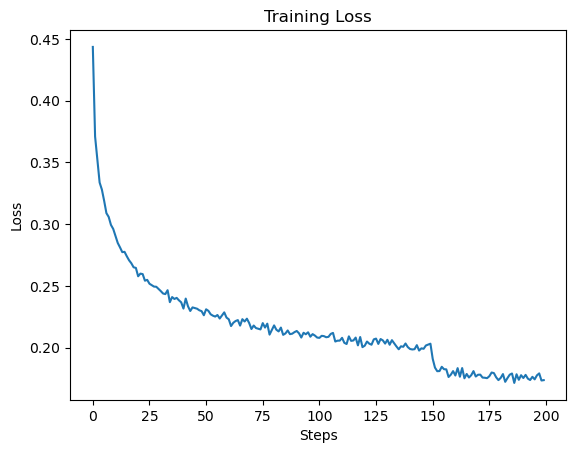

In [12]:
plt.title('Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [13]:
# train and validation loss

# put layers into eval mode
for layer in model.layers:
  layer.training = False

with torch.no_grad():
    train_logits = model(xs_train)
    train_loss = F.cross_entropy(train_logits, ys_train)
    
    val_logits = model(xs_dev)
    val_loss = F.cross_entropy(val_logits, ys_dev)
    
print(f'Train Loss     : {train_loss.item():.4f}')
print(f'Validation Loss: {val_loss.item():.4f}')

Train Loss     : 1.4684
Validation Loss: 1.5074


So, We are not overfitting this model. Maybe slight but not very much.

In [14]:
# sampling from model

out = []
context = [0] * context_size # initialize with all ...
for _ in range(500):
  # forward pass the neural net
  logits = model(torch.tensor([context]))
  probs = F.softmax(logits, dim=1)
  # sample from the distribution
  ix = torch.multinomial(probs, num_samples=1).item()
  # shift the context window and track the samples
  context = context[1:] + [ix]
  out.append(ix)
  # if we sample the special '.' token, break
output = ''.join([itoch[i] for i in out])
output = output.replace('<D>', '')
print(output)

Why, and you, how no morrow and his you from your at do, he should nows I do must besier be said is such very back, why, seans begin
 to from not,
's to rain hurderer:
 exous he tao, she if gravess are crom falthy, then, by thy king couplish'd. What, ales come depent ill; he roke.
e I see;
ist men.
es.
ing gentle a furthy appenitor, my lord,
's deeps,

, opition of the seat,
's see like remove with Wilt me, shunt,
, and they couch on the earl unllow, and so-prapes, dissembling them, 


# Conclusion

This is a way better model that generates many meaningful words.